# Unsupervised ML - Identify phases

In [1]:
# Code inspired by L. Wang, Discovering Phase Transitions with Unsupervised Learning, Phys. Rev. B 94 (2016). https://doi.org/10.1103/PhysRevB.94.195105.
# Code generated with assistance of ChatGPT (23 July 2025)

In [4]:
# ------------------------------------------------------------
# 1a. Mount Google Drive (do this once per Colab session)
# ------------------------------------------------------------
import pickle
from google.colab import drive
drive.mount('/content/drive')
path_dir = "/content/drive/MyDrive/AI-in-physics_AJP_2025/Phase transitions/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# ------------------------------------------------------------
# 1b. If you are on a local machine, set dir to current working tree
# ------------------------------------------------------------

import pickle
path_dir = '../Phase transitions/' # needs to be adapted to specific context

In [6]:
# ------------------------------------------------------------
# 1c. If you use the binder version
# ------------------------------------------------------------

import pickle
path_dir = './' # needs to be adapted to specific context

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/732.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/732.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/732.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/732.2 kB ? eta -:--:--
   ---------------------------- ----------- 524.3/732.2 kB 2.1 MB/s eta 0:00:01
   ---------------------------- ----------- 524.3/732.2 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 732.2/732.2 kB 1.0 MB/s eta 0:00:00


## Mount and load data

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import hdbscan

# ------------------------------------------------------------
# 1. load the dict from pickle  (already done)
# ------------------------------------------------------------
N = 80
pkl_path = path_dir + f"mc_samples_{N}.pickle"
with open(pkl_path, "rb") as f:
    data = pickle.load(f)           # dict  {temperature: [arrays]}

# ------------------------------------------------------------
# 2. build (14*100) × (80*80) matrix + temperature vector
# ------------------------------------------------------------
temps          = sorted(data.keys())         # e.g. 1.6 … 2.9
samples_per_T  = 100
total_samples  = len(temps) * samples_per_T  # 1400
flat_size      = N * N                       # 6400

lattice_bank = np.empty((total_samples, flat_size), dtype=np.int8)
labels       = np.empty(total_samples,        dtype=np.float64)

row = 0
for T in temps:
    cfgs = data[T][:samples_per_T]           # first 100 configs at this T
    for cfg in cfgs:
        lattice_bank[row] = cfg.astype(np.int8)  # cfg already flattened
        labels[row]       = float(T)
        row += 1

print("lattice_bank shape:", lattice_bank.shape)   # (1400, 6400)
print("labels shape      :", labels.shape)         # (1400,)
print("Temperatures      :", temps)

lattice_bank shape: (1400, 6400)
labels shape      : (1400,)
Temperatures      : [1.6, 1.7000000000000002, 1.8000000000000003, 1.9000000000000004, 2.0000000000000004, 2.1000000000000005, 2.2000000000000006, 2.3000000000000007, 2.400000000000001, 2.500000000000001, 2.600000000000001, 2.700000000000001, 2.800000000000001, 2.9000000000000012]


## Perform t-SNE and HDBSCAN

C:\Program Files\Orange\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t‑SNE Local structure → 6 clusters


C:\Program Files\Orange\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t‑SNE Global structure → 7 clusters


C:\Program Files\Orange\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t‑SNE Balanced → 7 clusters
Saved: .ising_tsne_hdbscan_grid.png


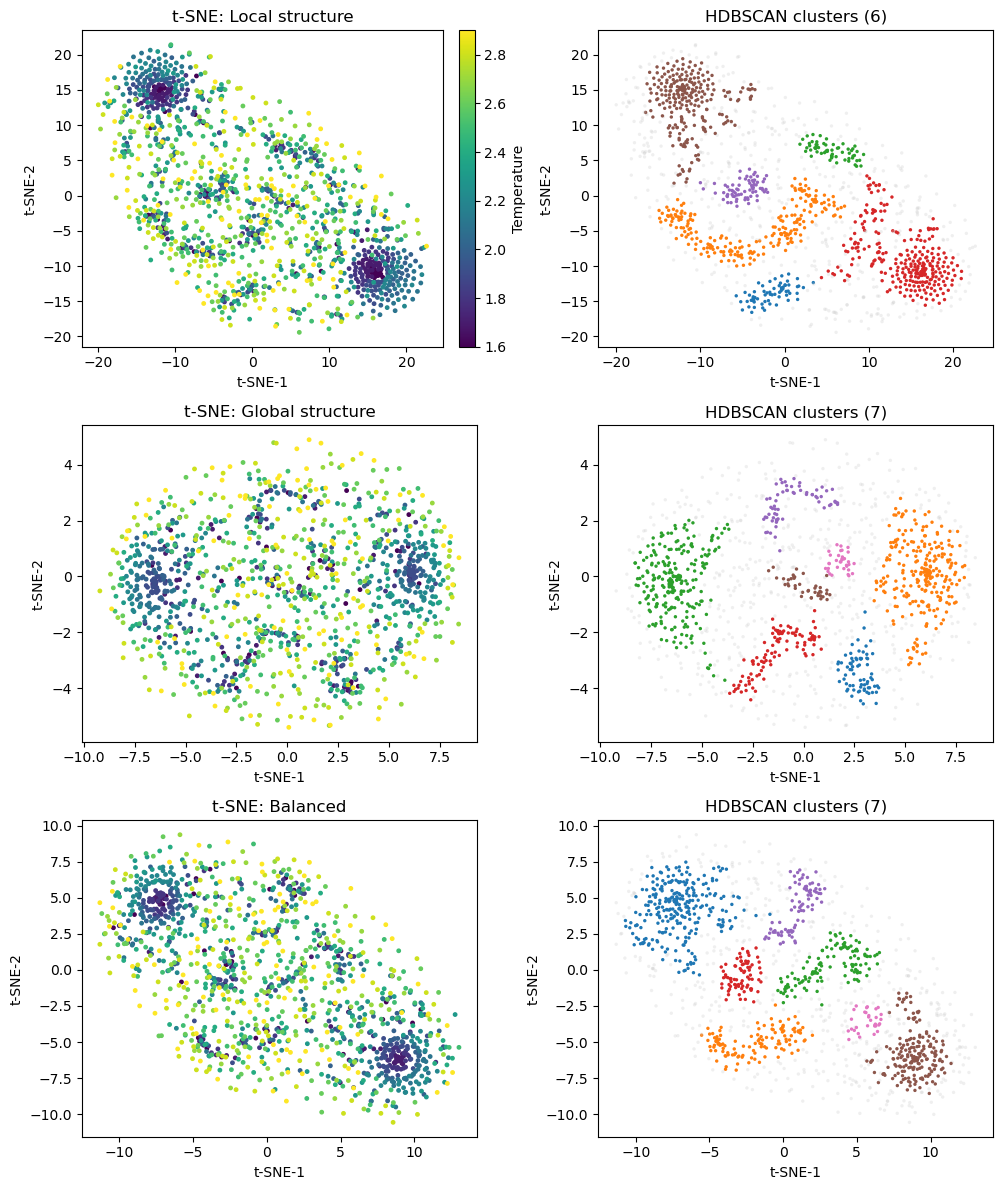

In [11]:
# ----- 1. parameter sets -------------------------------------
tsne_params = [
    dict(name='Local structure',
         perplexity=30,
         early_exaggeration=12),          # default EE emphasises local
    dict(name='Global structure',
         perplexity=150,
         early_exaggeration=4),           # low EE keeps global layout
    dict(name='Balanced',
         perplexity=80,
         early_exaggeration=8)
]

# ----- 2. figure ---------------------------------------------
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False          # keep TeX off

fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.subplots_adjust(hspace=0.35, wspace=0.20)

palette = plt.cm.tab10(np.linspace(0, 1, 10))   # for cluster colours

for row, p in enumerate(tsne_params):
    # ---------------------------------------------------------
    # run t‑SNE
    # ---------------------------------------------------------
    tsne = TSNE(
        n_components=2,
        perplexity=p['perplexity'],
        learning_rate=200.0,
        n_iter=10_000,
        early_exaggeration=p['early_exaggeration'],
        metric='euclidean',
        random_state=42,
        init='pca',          # stable start
        verbose=0
    )
    emb = tsne.fit_transform(lattice_bank.astype(float))

    # (row, 0): t‑SNE coloured by temperature
    ax_tsne = axes[row, 0]
    sc = ax_tsne.scatter(emb[:, 0], emb[:, 1],
                         c=labels, cmap='viridis', s=6)
    if row == 0:  # one colour‑bar for the whole grid
        cbar = fig.colorbar(sc, ax=ax_tsne, fraction=0.046, pad=0.04)
        cbar.set_label('Temperature')
    ax_tsne.set_xlabel('t‑SNE‑1')
    ax_tsne.set_ylabel('t‑SNE‑2')
    ax_tsne.set_title(f"t‑SNE: {p['name']}")

    # ---------------------------------------------------------
    # HDBSCAN clustering on same embedding
    # ---------------------------------------------------------
    clusterer = hdbscan.HDBSCAN(min_cluster_size=30,
                                min_samples=10,
                                metric='euclidean')
    clabels = clusterer.fit_predict(emb)
    n_clust = len(np.unique(clabels[clabels >= 0]))
    print(f"t‑SNE {p['name']} → {n_clust} clusters")

    colors = [palette[l % 10] if l >= 0 else (0.8, 0.8, 0.8, 0.3)
              for l in clabels]

    ax_clu = axes[row, 1]
    ax_clu.scatter(emb[:, 0], emb[:, 1],
                   c=colors, s=6, linewidth=0)
    ax_clu.set_xlabel('t‑SNE‑1')
    ax_clu.set_ylabel('t‑SNE‑2')
    ax_clu.set_title(f"HDBSCAN clusters ({n_clust})")

# ----- 3. finalise -------------------------------------------
plt.tight_layout()

# ---- Option A: 100 % raster PNG (simplest, smallest) --------
png_path = path_dir + "ising_tsne_hdbscan_grid.png"
fig.savefig(png_path, dpi=300, bbox_inches="tight")
print("Saved:", png_path)